In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import scipy.stats as stats
import statsmodels.formula.api as smf

In [69]:
homes = pd.read_csv('Data/homes_may_17.csv')

Our data is a snapshot of all of the single-family listings in Los Angles on May 17 from Realtor.com. It was extracted as a json file with a scrapper and converted to a csv. 

In [70]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

In [71]:
homes.head()

,id,price,beds,baths,garage,stories,house_type,lot_sqft,sqft,year_built,address,postal_code,state,city,tags,sold_price,sold_date,type,lat,lon,county,baseball,basement,basketball,basketball_court,beach,beautiful_backyard,big_bathroom,big_lot,big_yard,carport,cathedral_ceiling,central_air,central_heat,city_view,clubhouse,coffer_ceiling,community_boat_facilities,community_clubhouse,community_elevator,community_golf,community_gym,community_horse_facilities,community_outdoor_space,community_park,community_security_features,community_swimming_pool,community_tennis_court,conversation_pit,corner_lot,courtyard_entry,courtyard_style,cul_de_sac,den_or_office,detached_guest_house,dining_room,disability_features,dishwasher,dual_master_bedroom,efficient,elevator,energy_efficient,ensuite,equestrian,exposed_brick,family_room,farm,fenced_yard,fireplace,first_floor_master_bedroom,fixer_upper,floor_plan,forced_air,front_porch,fruit_trees,furniture,game_room,garage_1_or_more,garage_2_or_more,garage_3_or_more,gated_community,golf_course,golf_course_lot_or_frontage,golf_course_view,gourmet_kitchen,granite_kitchen,greenbelt,greenhouse,groundscare,guest_house,guest_parking,handicap_access,hardwood_floors,hidden_room,high_ceiling,hill_or_mountain_view,hoa,hollywood_sign_view,horse_facilities,horse_property,horse_stables,in_law_unit,indoor_basketball_court,investment_opportunity,jack_and_jill_bathroom,kitchen_island,kosher_diner,lake,lake_view,large_kitchen,large_porch,laundry_room,lease_option,library,low_hoa,maintenance,marina,master_bathroom,master_bedroom,master_suite,media_room,medicalcare,modern_kitchen,mountain_view,new_construction,new_roof,no_hoa,ocean_view,open_floor_plan,open_house,open_kitchen,outbuilding,outdoor_kitchen,park,pets_allowed,playground,pond,private_backyard,private_bathroom,private_courtyard,private_parking,ranch,recording_studio,recreation_facilities,rental_property,river_view,runway,rv_or_boat_parking,rv_parking,security,senior_community,shopping,single_story,smart_homes,soccer,solar_panels,solar_system,spa_or_hot_tub,swimming_pool,tennis,tennis_court,theater_room,trails,two_kitchen,two_master_suites,two_or_more_stories,updated_kitchen,vaulted_ceiling,view,views,volleyball,washer_dryer,water_view,waterfront,white_kitchen,wine_cellar,wooded_land,wrap_around_porch
0,2681523432,4480000,4.0,5.0,NaN,2.0,single_family,8999.0,3410.0,1946.0,12427 W Sunset Blvd,90049,CA,Los Angeles,"['central_air', 'central_heat', 'den_or_office...",2728000.0,2022-06-14,mls,34.058064,-118.481655,Los Angeles,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0
1,1431594678,3995000,5.0,7.0,NaN,2.0,single_family,11857.0,4100.0,1951.0,6349 W 78th St,90045,CA,Los Angeles,"['central_air', 'central_heat', 'community_out...",2125000.0,2017-09-14,mls,33.971306,-118.397921,Los Angeles,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0
2,2267633354,1998000,5.0,4.0,NaN,2.0,single_family,5953.0,2607.0,1939.0,3573 Greenfield Ave,90034,CA,Los Angeles,"['central_air', 'central_heat', 'city_view', '...",488500.0,1999-09-16,mls,34.019258,-118.417126,Los Angeles,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0
3,1609470097,1149000,4.0,3.0,2.0,2.0,single_family,16862.0,2846.0,1963.0,11562 Andasol

## Cleaning

### Dropping, Fixing, and Combining Columns

For flipping single family homes, in general even after fixing up the home, the price will not exceed 5 million dollars so we will restrict our analysis to homes listed below 5 million dollars.

In [72]:
homes_cleaned  = homes.copy()

homes_cleaned = homes_cleaned.loc[homes_cleaned['price'] < 5000000]

Getting rid of meaningless or useless columns.

In [73]:
homes_cleaned.drop(columns=['id', 'house_type', 'tags', 'view', 'views', 'county', 'state'], inplace = True)

The basketball and basketball_court columns seem to be describing the same feature. It can be seen that .894 percent of their rows are identical, so it is a relatively safe assumption. The difference can be due to the indoor_basketball_court column, which may be exclusively labeled as 1.

In [74]:
(homes_cleaned['basketball'] == homes_cleaned['basketball_court']).sum()/len(homes)

0.8944487881157154

To deal with this I am going to make the assumption that if at least one of these variables for any given row takes on the value of 1, then the house does indeed have a basketball court, so I will adjust basketball_court to take on 1 if basketball takes on 1. Afterwards, the basketball column will be dropped as it is redundant. We will also mark a 1 in the column of indoor_basketball_court as simply containing a basketball_court, and delete the indoor_basketball_court column. Generally indoor basketabll courts are for very expensive homes, which are outside the scope of flipping houses. 

In [75]:
homes_cleaned['basketball_court'] = homes_cleaned['basketball_court'] | homes_cleaned['basketball'] | homes_cleaned['indoor_basketball_court']

homes_cleaned.drop(columns=['basketball', 'indoor_basketball_court'] , inplace=True)

There is also a similar issue with the columns tennis and tennis_court, so we will do the same thing with those columns.

In [76]:
homes_cleaned['tennis_court'] = homes_cleaned['tennis_court'] | homes_cleaned['tennis']

homes_cleaned.drop(columns=['tennis'] , inplace=True)

There are binary columns relating to number of beds, baths, and garages which are redundant. We will drop these columns. 

In [77]:
homes_cleaned.drop(columns = ['garage_1_or_more', 'garage_2_or_more', 'garage_3_or_more', 'two_or_more_stories', 'single_story'], inplace=True)

### Missing Values

Homes without a price, stories, sqft or lot sqft will dropped. Similarly any home with less than 300 sqft will be dropped. 

In [78]:
homes_cleaned.dropna(subset=['price', 'stories', 'lot_sqft', 'sqft'], inplace=True)

homes_cleaned = homes_cleaned.loc[homes_cleaned['sqft'] > 300]

Missing values for bed, bath, and garage should be encoded as zero.

In [79]:
homes_cleaned['garage'] = homes_cleaned['garage'].fillna(0)

homes_cleaned['beds'] = homes_cleaned['beds'].fillna(0)

homes_cleaned['baths'] = homes_cleaned['baths'].fillna(0)

Missing values for year built will be encoded as the median year built. Median is chosen over mean because the distribution of year built is skewed to the right.

In [80]:
homes_cleaned['year_built'] = homes_cleaned['year_built'].fillna(homes_cleaned['year_built'].median())

## Univeriate Analysis

For Univeriate Analysis, I will focus on price, sqft, and year built.

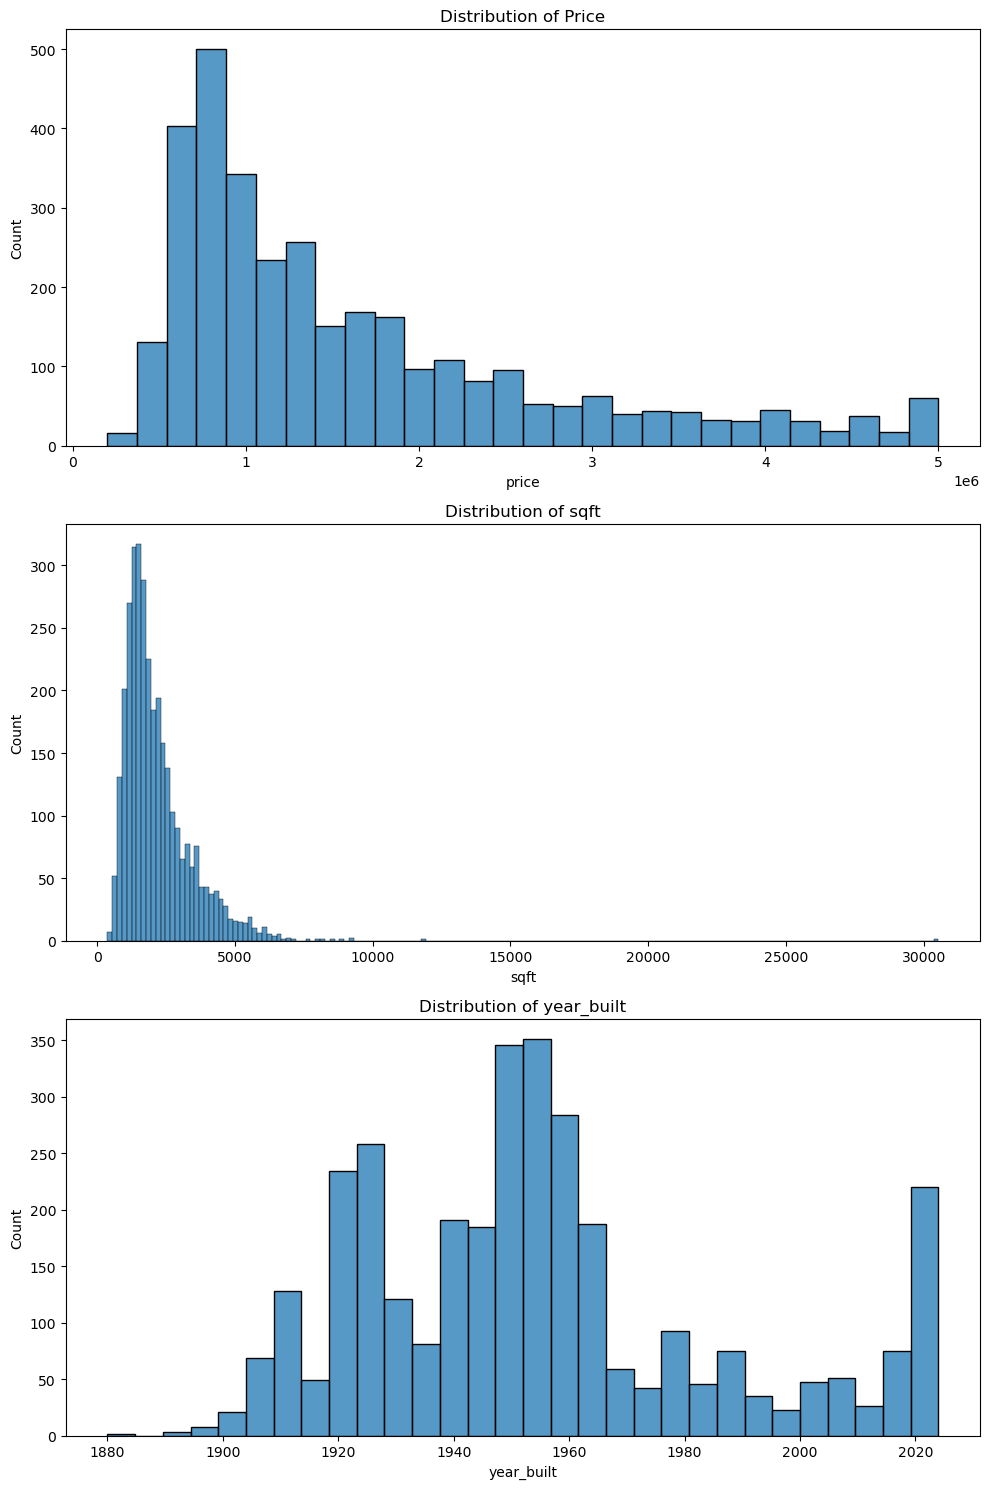

In [81]:
fig, axs = plt.subplots(3, 1, figsize=(10, 15))  # Adjust size as per your requirement

sns.histplot(data=homes_cleaned, x = 'price' ,ax=axs[0])
axs[0].set_title('Distribution of Price')

sns.histplot(data=homes_cleaned, x = 'sqft', ax=axs[1])
axs[1].set_title('Distribution of sqft')


sns.histplot(data=homes_cleaned, x = 'year_built' ,ax=axs[2])
axs[2].set_title('Distribution of year_built')

plt.tight_layout()  
plt.show()

It can be seen from the histograms that both the price and square footage of a home have distributions skewed right. There seems to be a extreme point in the square footage variable. The year built variable seems to follow a multimodal distribution with various local maximas. 

In [82]:
homes_cleaned[['price','sqft','year_built']].describe()

,price,sqft,year_built
count,3.309000e+03,3309.000000,3309.000000
mean,1.628729e+06,2182.304322,1954.628891
std,1.104788e+06,1285.770285,30.996091
min,2.000000e+05,376.000000,1880.000000
25%,7.999000e+05,1350.000000,1929.000000
50%,1.250000e+06,1827.000000,1951.000000
75%,2.100000e+06,2658.000000,1965.000000
max,4.999999e+06,30534.000000,2024.000000


The square footage variable has a maximum value which is more than a order of magnitude standard deviations above the mean. This should be further analyzed in the context of applying a model to determine if it should be dealt with and how. Transforming the variable to a log scale may be a good idea.

## Bivariate Analysis

### PPSQFT by City

For Bivariate Aanalysis, I will first make a new variable which will be the price per square feet. Then I will observe how the city variable effects the price per square feet.

In [83]:
homes_cleaned['PPSQFT'] = homes_cleaned['price']/homes_cleaned['sqft']

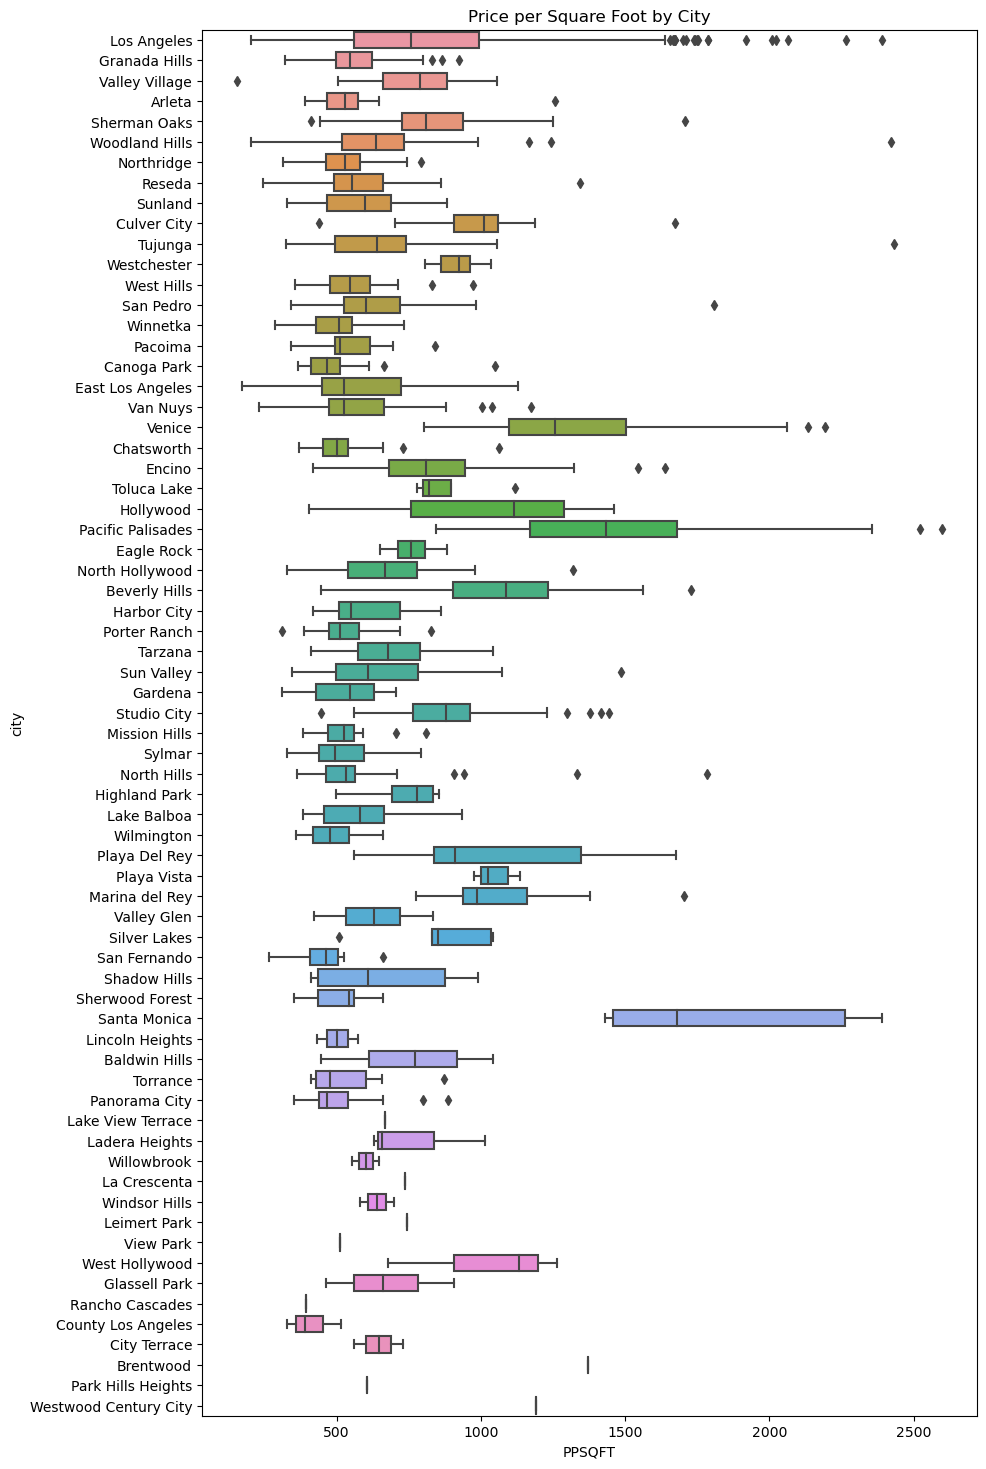

In [84]:
fig, ax = plt.subplots(figsize=(10, 18))
sns.boxplot(data=homes_cleaned, x='PPSQFT', y='city', ax=ax)
ax.set_title('Price per Square Foot by City')
plt.show()

Observing the graph above, it can be seen that Santa Monica seems to have the highest price per square footage. We can also see that the cities in our cleaned dataset have a lot of variability in their respective variances for each city. There also seems to be a variety of distributions among the cities. For example, Santa Monica is skewed to the right, whereas Valley Glen seems to be very close to a normal distribution. 

In [85]:
model = smf.ols(formula='PPSQFT ~ city', data=homes_cleaned).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 PPSQFT   R-squared:                       0.316
Model:                            OLS   Adj. R-squared:                  0.302
Method:                 Least Squares   F-statistic:                     22.40
Date:                Thu, 01 Jun 2023   Prob (F-statistic):          1.86e-216
Time:                        16:28:11   Log-Likelihood:                -22988.
No. Observations:                3309   AIC:                         4.611e+04
Df Residuals:                    3241   BIC:                         4.653e+04
Df Model:                          67                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                       557.7370     58.350      9.558      0.000     443.330     672.144
city[T.Baldwin Hills]           200.1254    139.919      1.430      0.153     -74.214     474.465
city[T.Beverly Hills]           515.6608     73.247      7.040      0.000     372.046     659.276
city[T.Brentwood]               814.6456    260.951      3.122      0.002     303.000    1326.291
city[T.Canoga Park]             -46.5929     84.912     -0.549      0.583    -213.080     119.894
city[T.Chatsworth]              -36.3169     75.599     -0.480      0.631    -184.543     111.909
city[T.City Terrace]             88.5511    189.077      0.468      0.640    -282.171     459.273
city[T.County Los Angeles]     -145.7003    158.014     -0.922      0.357    -455.517     164.116
city[T.Culver City]             439.5279     80.531      5.458      0.000     281.631     597.425
city[T.Eagle Rock]              204.2950    119.107      1.715      0.086     -29.238     437.828
city[T.East Los Angeles]         27.6851     96.363      0.287      0.774    -161.252     216.623
city[T.Encino]                  262.9548     63.810      4.121      0.000     137.843     388.066
city[T.Gardena]                 -21.8157     84.912     -0.257      0.797    -188.303     144.672
city[T.Glassell Park]           119.2593    158.014      0.755      0.450    -190.557     429.076
city[T.Granada Hills]             8.1590     65.696      0.124      0.901    -120.650     136.968
city[T.Harbor City]              41.8397     91.548      0.457      0.648    -137.657     221.337
city[T.Highland Park]           178.8005    107.197      1.668      0.095     -31.379     388.980
city[T.Hollywood]               435.2411    158.014      2.754      0.006     125.424     745.058
city[T.La Crescenta]            177.9401    260.951      0.682      0.495    -333.705     689.586
city[T.Ladera Heights]          209.3626    158.014      1.325      0.185    -100.454     519.179
city[T.Lake Balboa]              16.6461     73.247      0.227      0.820    -126.969     160.261
city[T.Lake View Terrace]       109.5563    260.951      0.420      0.675    -402.089     621.202
city[T.Leimert Park]            185.5934    260.951      0.711      0.477    -326.052     697.239
city[T.Lincoln Heights]         -54.8612    189.077     -0.290      0.772    -425.584     315.861
city[T.Los Angeles]             240.1035     58.698      4.091      0.000     125.015     355.192
city[T.Marina del Rey]          522.7630     93.785      5.574      0.000     338.879     706.647
city[T.Mission Hills]           -16.5460     91.548     -0.181      0.857    -196.043     162.951
city[T.North Hills]              33.8511     71.786      0.472      0.637    -106.899     174.601
city[T.North Hollywood]         108.8731     

Fitting a basic linear regression model to the data, we can see that the highest coefficient is for the city of Santa Monica, and this is a statistically significant number. This provides evidence for what we observed visually in the graph above.

### PPSQFT by Stories

It is also interesting to see if the price added by square footage remains constant across the number of stories, or if there is a diminishing or increasing effect. 

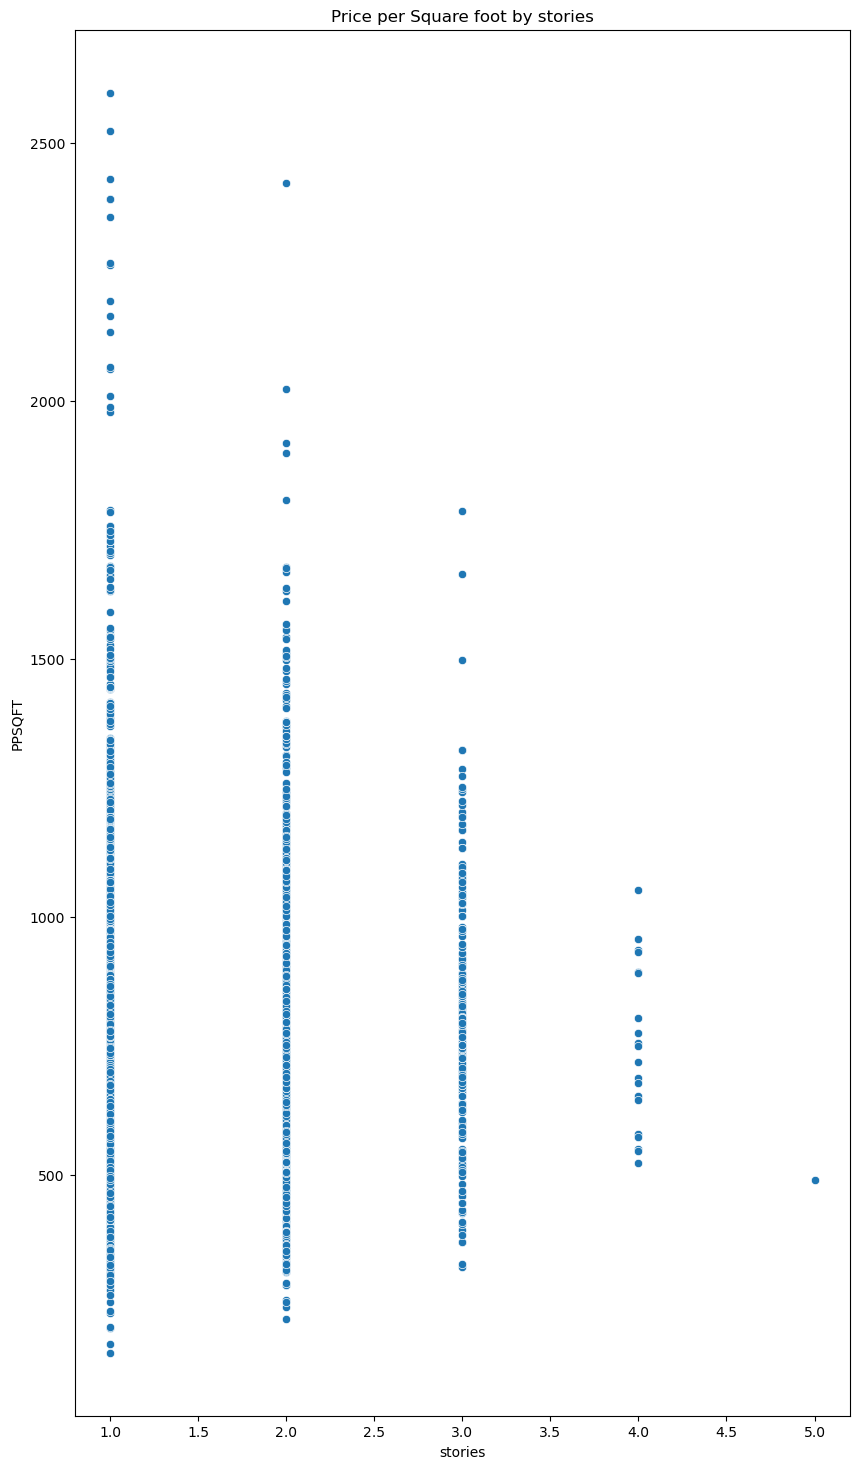

In [86]:
fig, ax = plt.subplots(figsize=(10, 18))
sns.scatterplot(data=homes_cleaned, x='stories', y='PPSQFT', ax=ax)
ax.set_title('Price per Square foot by stories')
plt.show()


In [87]:
model = smf.ols(formula='PPSQFT ~ C(stories)', data=homes_cleaned).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 PPSQFT   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     3.047
Date:                Thu, 01 Jun 2023   Prob (F-statistic):             0.0161
Time:                        16:28:43   Log-Likelihood:                -23612.
No. Observations:                3309   AIC:                         4.723e+04
Df Residuals:                    3304   BIC:                         4.726e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept           736.9098      6.602    111.614      0.000     723.965     749.855
C(stories)[T.2.0]    28.3680     11.784      2.407      0.016       5.264      51.472
C(stories)[T.3.0]    62.3717     22.812      2.734      0.006      17.645     107.099
C(stories)[T.4.0]     0.4268     66.695      0.006      0.995    -130.342     131.195
C(stories)[T.5.0]  -245.8384    304.207     -0.808      0.419    -842.292     350.615
==============================================================================
Omnibus:                      907.866   Durbin-Watson:                   1.879
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2692.383
Skew:                           1.411   Prob(JB):                         0.00
Kurtosis:                       6.400   Cond. No.                         60.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We can see from the summary outputs that there seems to be a increasing effect on price per square footage as the number of stories increases, which is statistically significant up to 3 stories. So adding a additional story on a house instead expanding the house horizontally could reap more rewards for investors. The data does not contain many homes with more than 3 stories, so the lack of statistical significance for 4 stories and above is not surprising. However, for the purposes of flipping homes, more than 3 stories is not very relevant.